<a href="https://colab.research.google.com/github/Abhishek3102/Variational-AutoEncoders/blob/main/Stable_Diffusion_Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

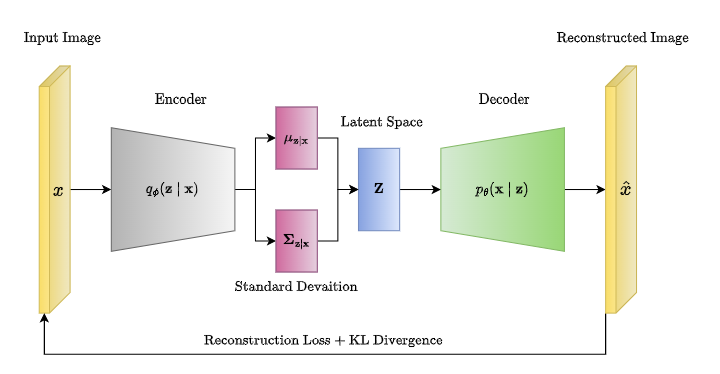

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import math
import os
import shutil
from sklearn.model_selection import train_test_split
import os

## Self Attention

Self Attention is machanism which achieve attention in a single sequence, means it calculates attention among all the tokens within single sequence. Attention help us to pay attention with different intensity among all tokens in the sequence. Self-attention is widely used in the encoder part of the Transformer model, where the model needs to understand and encode the entire input sequences' context.


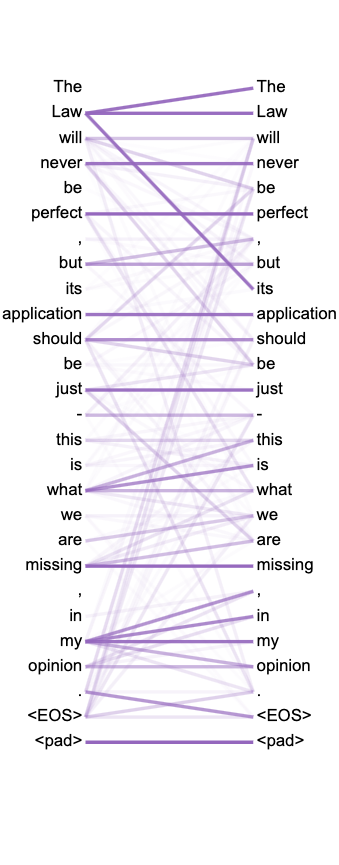



Attention formula :


 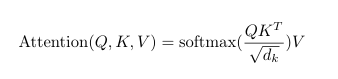

Comment Overview:

init function:
Initializes layers and necessary parameters for multi-head self-attention.

forward function:
Takes the input and computes the self-attention with optional causal masking.

Query, Key, and Value computation:
Projects the input to get queries, keys, and values, and reshapes them for multi-head attention.

Attention Weight Calculation:
Computes attention scores via the dot product between queries and keys, applying scaling and optional masking.

Attention Output:
The weighted values are computed based on the attention scores and then passed through a final linear layer to get the output.

Key Operations:

chunk: Splits the input into query, key, and value tensors.

view: Reshapes tensors for multi-head attention compatibility.

transpose: Reorders the dimensions to align for dot product computation.

softmax: Converts the attention scores to probabilities.

masked_fill_: Applies a mask to prevent attention to certain positions (e.g., future positions for causal masking).

out_proj: Projects the attention output back to the original embedding dimension.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, n_heads, embd_dim, in_proj_bias=True, out_proj_bias=True):
        super().__init__()

        self.n_heads = n_heads
        self.in_proj = nn.Linear(embd_dim, 3 * embd_dim, bias=in_proj_bias)  # Linear projection for query, key, and value
        self.out_proj = nn.Linear(embd_dim, embd_dim, bias=out_proj_bias)  # Output linear projection

        self.d_heads = embd_dim // n_heads  # Dimension of each attention head

    def forward(self, x, casual_mask=False):
        batch_size, seq_len, d_emed = x.shape  # Input shape: (batch_size, seq_len, d_embed)

        interim_shape = (batch_size, seq_len, self.n_heads, self.d_heads)  # Intermediate shape for q, k, v

        q, k, v = self.in_proj(x).chunk(3, dim=-1)  # Split the input into query, key, and value

        q = q.view(interim_shape)  # Reshape query to (batch_size, seq_len, n_heads, d_head)
        k = k.view(interim_shape)  # Reshape key to (batch_size, seq_len, n_heads, d_head)
        v = v.view(interim_shape)  # Reshape value to (batch_size, seq_len, n_heads, d_head)

        q = q.transpose(1, 2)  # Transpose to (batch_size, n_heads, seq_len, d_head)
        k = k.transpose(1, 2)  # Transpose to (batch_size, n_heads, seq_len, d_head)
        v = v.transpose(1, 2)  # Transpose to (batch_size, n_heads, seq_len, d_head)

        weight = q @ k.transpose(-1, -2)  # Calculate attention weights (dot product between query and key)

        if casual_mask:
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)  # Create an upper triangular mask
            weight.masked_fill_(mask, -torch.inf)  # Apply the mask (set upper triangle to -inf)

        weight /= math.sqrt(self.d_heads)  # Scale weights by sqrt of d_head (dimension of each head)

        weight = F.softmax(weight, dim=-1)  # Apply softmax to get the attention probabilities

        output = weight @ v  # Weighted sum of values (attended values)

        output = output.transpose(1, 2)  # Transpose output to (batch_size, seq_len, n_heads, d_head)

        output = output.reshape((batch_size, seq_len, d_emed))  # Reshape back to (batch_size, seq_len, d_embed)

        output = self.out_proj(output)  # Apply output linear projection

        return output  # Return the final attended output

This Attention Block uses self attention using residual technique with group norms as all the features we have are pixel values and attention tries to find what are good features to pay attention in all features.

In [4]:
import torch
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)  # Group normalization layer
        self.attention = SelfAttention(1, channels)  # Self-attention layer with 1 head

    def forward(self, x):
        residual = x.clone()  # Store the input for the residual connection

        x = self.groupnorm(x)  # Apply group normalization to the input

        n, c, h, w = x.shape  # Get the shape of the input (batch_size, channels, height, width)

        x = x.view((n, c, h * w))  # Flatten the spatial dimensions (height * width)

        x = x.transpose(-1, -2)  # Transpose to (batch_size, h * w, channels)

        x = self.attention(x)  # Apply self-attention to the reshaped input

        x = x.transpose(-1, -2)  # Transpose back to (batch_size, channels, h * w)

        x = x.view((n, c, h, w))  # Reshape back to original spatial dimensions

        x += residual  # Add the residual connection (skip connection)

        return x  # Return the final output after attention and residual addition

This Implements ResidualBlock which we use in Encoder and Decoder

Key Operations:

groupnorm: Applies normalization to the input to improve training stability.

view: Reshapes the input tensor for compatibility with the self-attention mechanism.

transpose: Changes the shape to make the input compatible with the self-attention layer.

self.attention: Performs the self-attention operation on the reshaped input.

Residual Addition: Adds the original input back to the output after the attention operation to maintain information flow (skip connection).

This structure ensures that after applying the attention mechanism, the model retains the original input information through the residual connection, allowing better gradient flow and avoiding vanishing gradients during training.





In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm1 = nn.GroupNorm(32, in_channels)  # Group normalization for the first convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)  # First convolution layer

        self.groupnorm2 = nn.GroupNorm(32, out_channels)  # Group normalization for the second convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)  # Second convolution layer

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()  # If input and output channels match, skip connection is identity
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)  # Conv layer for matching dimensions

    def forward(self, x):
        residue = x.clone()  # Store the input for the residual connection

        x = self.groupnorm1(x)  # Apply group normalization to the input
        x = F.selu(x)  # Apply SELU activation function
        x = self.conv1(x)  # Apply the first convolution layer
        x = self.groupnorm2(x)  # Apply group normalization after first conv
        x = self.conv2(x)  # Apply the second convolution layer

        return x + self.residual_layer(residue)  # Add the residual connection (skip connection) and return the result

Key Operations:

groupnorm1, groupnorm2: Applies group normalization to stabilize training and speed up convergence.

conv1, conv2: Convolution layers that learn spatial features from the input.

F.selu: Applies the SELU (Scaled Exponential Linear Unit) activation function for non-linearity.

Residual connection (residual_layer): Adds the original input (x) back to the output. If the input and output dimensions don't match, a 1x1 convolution is used to adjust the dimensions.

Identity: If the input and output dimensions match, the residual connection is simply the input itself (identity).

This block is a typical residual block found in many architectures like ResNet, where the input is added back to the output to help with training deeper networks.

This is Encoder which help us to encode the images in latents with lower dimensions, it consist of convolutional layers to extract features, residual block to maintain and allow to build deeper networks. In the forward method we extract mean and standard divation from the output of the encoder and build the final latents 'z' with them.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),  # (batch_size, 3, h, w) -> (batch_size, 128, h, w)

            ResidualBlock(128, 128),  # Apply Residual Block with input/output channels 128

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),  # Downsample to (batch_size, 128, h/2, w/2)

            ResidualBlock(128, 256),  # Apply Residual Block with input channels 128 and output channels 256

            ResidualBlock(256, 256),  # Apply Residual Block with input/output channels 256

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),  # Downsample to (batch_size, 256, h/4, w/4)

            ResidualBlock(256, 512),  # Apply Residual Block with input channels 256 and output channels 512

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),  # Downsample to (batch_size, 512, h/8, w/8)

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            AttentionBlock(512),  # Apply Attention Block to the (batch_size, 512, h/8, w/8) tensor

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            nn.GroupNorm(32, 512),  # Apply GroupNorm to normalize activations (batch_size, 512, h/8, w/8)

            nn.SiLU(),  # Apply SiLU (Sigmoid Linear Unit) activation

            nn.Conv2d(512, 8, kernel_size=3, padding=1),  # Downsample to (batch_size, 8, h/8, w/8)

            nn.Conv2d(8, 8, kernel_size=1, padding=0)  # Apply 1x1 convolution to output
        )

    def forward(self, x):
        # x: (batch_size, channel, h, w)

        for module in self:
            if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
                x = F.pad(x, (0, 1, 0, 1))  # Pad the input when downsampling to preserve spatial dimensions
            x = module(x)  # Apply each module in the Sequential

        # Split the output into two tensors: mean and log_variance (for variational autoencoding)
        mean, log_variance = torch.chunk(x, 2, dim=1)

        # Clamp the log_variance between -30 and 20 for stability
        log_variance = torch.clamp(log_variance, -30, 20)

        # Reparameterization trick for the Variational Autoencoder (VAE)
        std = torch.exp(0.5 * log_variance)  # Standard deviation
        eps = torch.randn_like(std)  # Sample from standard normal distribution
        x = mean + eps * std  # Reparameterized latent variable

        # Scale the latent representation (important for VAE stability)
        x *= 0.18215

        return x  # Return the encoded latent representation

Key Operations:

Conv2d layers: Convolution layers for extracting features and downsampling the input spatial dimensions.

ResidualBlock: A residual block that helps mitigate the vanishing gradient problem by adding the input back to the output.

AttentionBlock: Applies self-attention on the feature maps to capture long-range dependencies.

GroupNorm: Normalizes activations by groups to improve training stability.

SiLU: Activation function (Sigmoid-weighted Linear Unit) used for non-linearity.
torch.chunk: Splits the output tensor into two parts (mean and log_variance) for VAE latent variable computation.

Reparameterization trick: A method used in variational autoencoders (VAEs) to sample from a distribution defined by the mean and log_variance.

Final Output:
The output x is a latent representation of the input, scaled and reparameterized for use in the next stage of the VAE or other models.




Decoder decode the latents to the original output, it also consist of attnetion block, residual block and Upsample layer which add features to add more dimensions to the image to turn back to original image

In [8]:
class Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(4, 512, kernel_size=3, padding=1),  # (batch_size, 4, 32, 32) -> (batch_size, 512, 32, 32)

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            AttentionBlock(512),  # Apply Attention Block to the feature map

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            nn.Upsample(scale_factor=2),  # Upsample to (batch_size, 512, 64, 64)

            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Convolution to (batch_size, 512, 64, 64)

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            ResidualBlock(512, 512),  # Apply Residual Block with input/output channels 512

            nn.Upsample(scale_factor=2),  # Upsample to (batch_size, 512, 128, 128)

            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Convolution to (batch_size, 512, 128, 128)

            ResidualBlock(512, 256),  # Apply Residual Block with input channels 512 and output channels 256

            ResidualBlock(256, 256),  # Apply Residual Block with input/output channels 256

            ResidualBlock(256, 256),  # Apply Residual Block with input/output channels 256

            nn.Upsample(scale_factor=2),  # Upsample to (batch_size, 256, 256, 256)

            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Convolution to (batch_size, 256, 256, 256)

            ResidualBlock(256, 128),  # Apply Residual Block with input channels 256 and output channels 128

            ResidualBlock(128, 128),  # Apply Residual Block with input/output channels 128

            ResidualBlock(128, 128),  # Apply Residual Block with input/output channels 128

            nn.GroupNorm(32, 128),  # Apply Group Normalization to normalize activations

            nn.SiLU(),  # Apply SiLU (Sigmoid Linear Unit) activation function

            nn.Conv2d(128, 3, kernel_size=3, padding=1),  # Final convolution to output (batch_size, 3, 256, 256)
        )

    def forward(self, x):
        # x: (batch_size, 4, h / 8, w / 8)

        # Remove the scaling applied by the encoder
        x /= 0.18215

        for module in self:
            x = module(x)  # Apply each module in the Sequential

        # (batch_size, 3, h, w) -> Return the final output (reconstructed image)
        return x

Key Operations:

Conv2d layers: Convolutional layers for feature extraction and dimensional transformations.

ResidualBlock: Helps maintain gradient flow by adding the input back to the output, ensuring easier training of deeper networks.

AttentionBlock: Applies self-attention to capture long-range dependencies within the feature map.

Upsample: Doubles the spatial dimensions of the input (height and width) for upsampling the feature map.

GroupNorm: Normalizes activations across groups of channels, helping with training stability.

SiLU: Activation function (Sigmoid-weighted Linear Unit) used for non-linearity.

Final Conv2d layer: Produces the output image with 3 channels (for RGB images).

Final Output:
The final output x is a reconstructed image of shape (batch_size, 3, h, w) after passing through all the layers. This output is generated by upsampling and transforming the encoded latent representation back to the original image space.

## Data Preprocessing

In [9]:
!gdown 1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV

Downloading...
From (original): https://drive.google.com/uc?id=1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV
From (redirected): https://drive.google.com/uc?id=1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV&confirm=t&uuid=e866c461-d886-444f-be8d-23bbb80e7c9a
To: /content/all-dogs.zip
100% 775M/775M [00:16<00:00, 48.1MB/s]


In [10]:
!unzip all-dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: all-dogs/n02113624_8890.jpg  
  inflating: all-dogs/n02107683_215.jpg  
  inflating: all-dogs/n02093428_5326.jpg  
  inflating: all-dogs/n02105412_8018.jpg  
  inflating: all-dogs/n02093647_3129.jpg  
  inflating: all-dogs/n02088466_8078.jpg  
  inflating: all-dogs/n02108915_4214.jpg  
  inflating: all-dogs/n02089078_2841.jpg  
  inflating: all-dogs/n02105855_3498.jpg  
  inflating: all-dogs/n02094114_2823.jpg  
  inflating: all-dogs/n02088094_649.jpg  
  inflating: all-dogs/n02091831_2232.jpg  
  inflating: all-dogs/n02096585_3105.jpg  
  inflating: all-dogs/n02109961_977.jpg  
  inflating: all-dogs/n02097047_5869.jpg  
  inflating: all-dogs/n02106030_16250.jpg  
  inflating: all-dogs/n02110958_13721.jpg  
  inflating: all-dogs/n02107142_8437.jpg  
  inflating: all-dogs/n02094433_1312.jpg  
  inflating: all-dogs/n02097474_5481.jpg  
  inflating: all-dogs/n02097130_1531.jpg  
  inflating: all-dogs/n02092339_284.jpg  
  inf

In [11]:
def split_dataset(source_dir, train_dir, test_dir, test_size=0.2, random_state=42):
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=random_state)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))

    print(f"Dataset split complete. {len(train_files)} training images, {len(test_files)} test images.")

source_dir = "./all-dogs"
train_dir = "./data/train/dogs"
test_dir = "./data/test/dogs"

split_dataset(source_dir, train_dir, test_dir)

Dataset split complete. 16463 training images, 4116 test images.


# **Implementing VAE**

In [12]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize the Encoder and Decoder components
        self.encoder = Encoder()  # Encoder maps input to latent space
        self.decoder = Decoder()  # Decoder reconstructs input from latent space

    def forward(self, x):
        # Forward pass through the encoder and decoder
        encoded = self.encoder(x)  # Encode the input into latent representation
        decoded = self.decoder(encoded)  # Decode the latent representation back to input space
        return decoded, encoded  # Return the reconstructed image and the latent representation

# **Training The VAE**

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10  # Number of training epochs
learning_rate = 1e-4  # Learning rate for the optimizer
beta = 0.00025  # Weight for the KL divergence loss (controls the balance between reconstruction and latent space regularization)

# Data loading and transformation
transform = transforms.Compose([
    transforms.Resize((56, 56)),  # Resize images to a fixed size (56x56)
    transforms.ToTensor(),  # Convert images to tensors (scaled to [0, 1])
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image data to the range [-1, 1]
])

# Reduce the dataset to the first 1000 images for faster experimentation (optional)
dataset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
subset_dataset = torch.utils.data.Subset(dataset, range(0, 1000))  # Select first 1000 samples
batch_size = 16  # Set the batch size
dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

# Initialize the VAE model and optimizer
model = VAE().to(device)  # Move the model to the GPU
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Use Adam optimizer

# Additional hyperparameters for gradient accumulation
accumulation_steps = 1  # Number of gradient accumulation steps before performing an optimizer update
effective_batch_size = batch_size * accumulation_steps  # Effective batch size after gradient accumulation

# List to track the training loss for each epoch
train_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize epoch training loss

    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)  # Move input images to the GPU

        # Forward pass: Generate reconstructed images and encoded latent space representation
        reconstructed, encoded = model(images)

        # Compute the reconstruction loss (MSE between original and reconstructed images)
        recon_loss = nn.MSELoss()(reconstructed, images)

        # Extract mean and log variance from the encoded latent space (assumes the output of the encoder is in this form)
        mean, log_variance = torch.chunk(encoded, 2, dim=1)  # Split the encoded latent space into mean and log_variance

        # Compute the KL divergence loss to regularize the latent space
        kl_div = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())  # KL divergence formula

        # Total loss: combine reconstruction loss and KL divergence
        loss = recon_loss + beta * kl_div

        # Normalize the loss if using gradient accumulation
        loss = loss / accumulation_steps

        # Backward pass: Compute gradients for the model
        loss.backward()

        # Perform optimization step after accumulation
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()  # Update model parameters
            optimizer.zero_grad()  # Reset gradients to prepare for the next step

        # Accumulate the training loss (adjusted for accumulation steps)
        train_loss += loss.item() * accumulation_steps

        # Print training progress and individual loss components
        if (i + 1) % 50 == 0:  # Print every 50 steps to reduce verbosity
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                  f'Loss: {loss.item()*accumulation_steps:.4f}, Recon Loss: {recon_loss.item():.4f}, KL Div: {kl_div.item():.4f}')

    # Record the average training loss for the epoch
    train_losses.append(train_loss / len(dataloader))

    # Save the model checkpoint after every epoch
    torch.save(model.state_dict(), f'vae_model_epoch_{epoch+1}.pth')

print('Training finished!')  # Print when training is complete


Epoch [1/10], Step [50/63], Loss: 0.2988, Recon Loss: 0.2553, KL Div: 173.9302
Epoch [2/10], Step [50/63], Loss: 0.2528, Recon Loss: 0.2331, KL Div: 78.6480
Epoch [3/10], Step [50/63], Loss: 0.1784, Recon Loss: 0.1610, KL Div: 69.5548
Epoch [4/10], Step [50/63], Loss: 0.1913, Recon Loss: 0.1633, KL Div: 111.9776
Epoch [5/10], Step [50/63], Loss: 0.1335, Recon Loss: 0.1196, KL Div: 55.3265
Epoch [6/10], Step [50/63], Loss: 0.1236, Recon Loss: 0.1139, KL Div: 38.9678
Epoch [7/10], Step [50/63], Loss: 0.0987, Recon Loss: 0.0898, KL Div: 35.2740
Epoch [8/10], Step [50/63], Loss: 0.0938, Recon Loss: 0.0869, KL Div: 27.3261
Epoch [9/10], Step [50/63], Loss: 0.0824, Recon Loss: 0.0769, KL Div: 21.8296
Epoch [10/10], Step [50/63], Loss: 0.0761, Recon Loss: 0.0701, KL Div: 23.9385
Training finished!


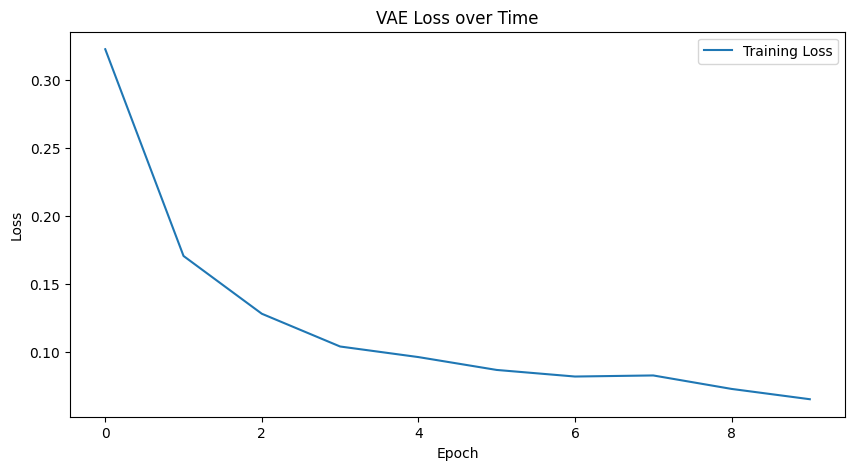

In [19]:
import matplotlib.pyplot as plt

# plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Loss over Time')
plt.legend()
plt.show()

In [20]:
!pip install pillow

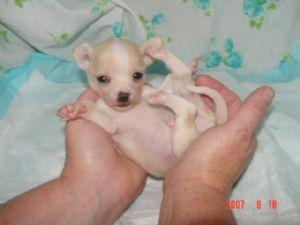

In [25]:
import cv2 as cv
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow

image_path = "/content/data/train/dogs/n02085620_11337.jpg"
image = cv.imread(image_path)
cv2_imshow(image)

<ipython-input-31-b0f05a22530e>:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load(model_path, map_location="cpu"))


Model loaded successfully.


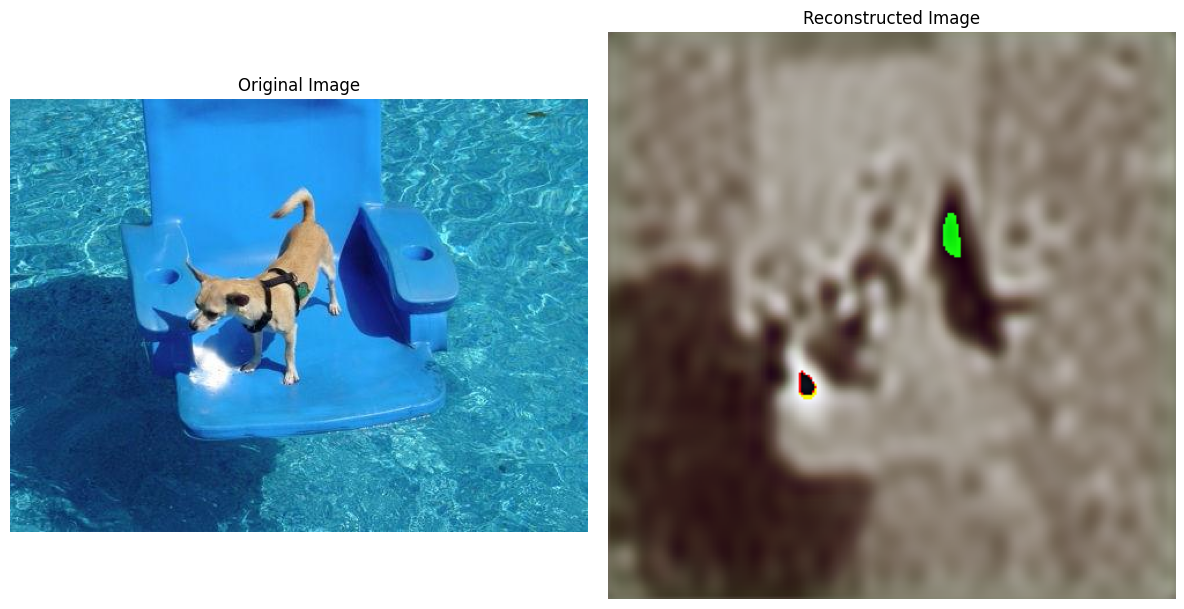

In [31]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Include Encoder, Decoder, ResidualBlock, AttentionBlock, and SelfAttention as defined above
# (Paste all the previously shared class definitions here)

class SelfAttention(nn.Module):
  def __init__(self, n_heads, embd_dim, in_proj_bias=True, out_proj_bias=True):
    super().__init__()
    self.n_heads = n_heads
    self.in_proj = nn.Linear(embd_dim, 3 * embd_dim, bias=in_proj_bias)
    self.out_proj = nn.Linear(embd_dim, embd_dim, bias=out_proj_bias)

    self.d_heads = embd_dim // n_heads

  def forward(self, x, casual_mask=False):
    # x: (batch_size, seq_len, dim)

    batch_size, seq_len, d_emed = x.shape

    interim_shape = (batch_size, seq_len, self.n_heads, self.d_heads)

    # (batch_size, seq_len, dim) -> 3 * (batch_size, seq_len, d_embed)
    q, k, v = self.in_proj(x).chunk(3, dim=-1)

    # change the shape of q, k and v to match the interim shape
    q = q.view(interim_shape)
    k = k.view(interim_shape)
    v = v.view(interim_shape)

    # swap the elements within matrix using transpose
    # take n_heads before seq_len, like that: (batch_size, n_heads, seq_len, d_embed)
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    # calculate the attention
    weight = q @ k.transpose(-1, -2)

    if casual_mask:
        # mask where the upper traingle (above the prinicpal dagonal) is 1
        mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
        # fill the upper traingle with -inf
        weight.masked_fill_(mask, -torch.inf)

    weight /= math.sqrt(self.d_heads)

    weight = F.softmax(weight, dim=-1)

    # (batch_size, h_heads, seq_len, dim / h)
    output = weight @ v

    # (batch_size, h_heads, seq_len, dim / h) -> (batch_size, seq_len, n_heads, dim / h)
    output = output.transpose(1, 2)

    # change the shape to the shape of out_proj
    output = output.reshape((batch_size, seq_len, d_emed))

    output = self.out_proj(output)

    return output





class AttentionBlock(nn.Module):
  def __init__(self, channels):
      super().__init__()
      self.groupnorm = nn.GroupNorm(32, channels)
      self.attention = SelfAttention(1, channels)

  def forward(self, x):
      # x: (batch_size, channels, h, w)
      residual = x.clone()

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x = self.groupnorm(x)

      n, c, h, w = x.shape

      # (batch_size, channels, h, w) -> (batch_size, channels, h * w)
      x = x.view((n, c, h * w))

      # (batch_size, channels, h * w) -> (batch_size, h * w, channels)
      x = x.transpose(-1, -2)

      # perform self-attention without mask
      # (batch_size, h * w, channels) -> (batch_size, h * w, channels)
      x = self.attention(x)

      # (batch_size, h * w, channels) -> (batch_size, channels, h * w)
      x = x.transpose(-1, -2)

      # (batch_size, channels, h * w) -> (batch_size, channels, h, w)
      x = x.view((n, c, h, w))

      # (batch_size, channels, h, w) -> (batch_size, channels, h, w)
      x += residual

      return x

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.groupnorm1 = nn.GroupNorm(32, in_channels)
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    self.groupnorm2 = nn.GroupNorm(32, out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    if in_channels == out_channels:
      self.residual_layer = nn.Identity()
    else:
      self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

  def forward(self, x):
    # x: (batch_size, in_channels, h, w)
    residue = x.clone()

    x = self.groupnorm1(x)
    x = F.selu(x)
    x = self.conv1(x)
    x = self.groupnorm2(x)
    x = self.conv2(x)

    return x + self.residual_layer(residue)


class Encoder(nn.Sequential):
    def  __init__(self):
        super().__init__(
            # (batch_size, channel, h, w) -> (batch_size, 128, h, w)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),

            # (batch_size, 128, h, w) -> (batch_size, 128, h, w)
            ResidualBlock(128, 128),

            # (batch_size, 128, h, w) -> (batch_size, 128, h / 2, w / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),

            # (batch_size, 128, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(128, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 2, w / 2)
            ResidualBlock(256, 256),

            # (batch_size, 256, h / 2, w / 2) -> (batch_size, 256, h / 4, w / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),

            # (batch_size, 256, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(256, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 4, w / 4)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 4, w / 4) -> (batch_size, 512, h / 8, w / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            AttentionBlock(512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            ResidualBlock(512, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.GroupNorm(32, 512),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 512, h / 8, w / 8)
            nn.SiLU(),

            # (batch_size, 512, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(512, 8, kernel_size=3, padding=1),

            # (batch_size, 8, h / 8, w / 8) -> (batch_size, 8, h / 8, w / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0)
        )
    def forward(self, x):
        # x: (batch_size, channel, h, w)

        for module in self:
            if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
                x = F.pad(x, (0, 1, 0, 1))  # (left, right, top, bottom)
            x = module(x)

        # (batch_size, 8, h / 8, w / 8) -> two tensors of shape (batch_size, 4, h / 8, w / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)

        # Clamp log variance between -30 and 20
        log_variance = torch.clamp(log_variance, -30, 20)

        # Reparameterization trick
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        x = mean + eps * std

        # Scale the latent representation
        x *= 0.18215

        return x


class Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (batch_size, 4, 32, 32) -> (batch_size, 512, 32, 32)
            nn.Conv2d(4, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_Size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            AttentionBlock(512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 32, 32)
            ResidualBlock(512, 512),

            # (batch_size, 512, 32, 32) -> (batch_size, 512, 64, 64)
            nn.Upsample(scale_factor=2),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 64, 64)
            ResidualBlock(512, 512),

            # (batch_size, 512, 64, 64) -> (batch_size, 512, 128, 128)
            nn.Upsample(scale_factor=2),

            # (batch_size, 512, 128, 128) -> (batch_size, 512, 128, 128)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # (batch_size, 512, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(512, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(256, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 128, 128)
            ResidualBlock(256, 256),

            # (batch_size, 256, 128, 128) -> (batch_size, 256, 256, 256)
            nn.Upsample(scale_factor=2),

            # (batch_size, 256, 256, 256) -> (batch_size, 256, 256, 256)
            nn.Conv2d(256, 256, kernel_size=3, padding=1),

            # (batch_size, 256, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(256, 128),

            # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(128, 128),

            # (batch_size, 128, 256, 256) -> (batch_size, 128, 256, 256)
            ResidualBlock(128, 128),

            nn.GroupNorm(32, 128),

            nn.SiLU(),

            # (batch_size, 128, 256, 256) -> (batch_size, 3, 256, 256)
            nn.Conv2d(128, 3, kernel_size=3, padding=1),
        )
    def forward(self, x):
        # x: (batch_size, 4, h / 8, w / 8)

        # remove the scaling adding by the encoder
        x /= 0.18215

        for module in self:
            x = module(x)

        # (batch_size, 3, h, w)
        return x

# Define VAE using the provided architecture
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Load the trained VAE model
model_path = '/content/vae_model_epoch_9.pth'
vae_model = VAE()

try:
    vae_model.load_state_dict(torch.load(model_path, map_location="cpu"))
    print("Model loaded successfully.")
except RuntimeError as e:
    print(f"Error loading model: {e}")
    exit()

vae_model.eval()

# Define the preprocessing steps
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for RGB images
])

# Load and preprocess a sample image
image_path = '/content/data/train/dogs/n02085620_9399.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Pass the image through the VAE
with torch.no_grad():
    reconstructed, latent = vae_model(image_tensor)

# Postprocess reconstructed image
reconstructed_image = reconstructed.squeeze(0)  # Remove batch dimension
reconstructed_image = reconstructed_image * 0.5 + 0.5  # De-normalize
reconstructed_image = transforms.ToPILImage()(reconstructed_image)

# Plot the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis("off")

plt.tight_layout()
plt.show()